# Resume Classifier: ML Modeling Notebook

In this notebook, we're going to:
- encode our data
- split it into train and test
- train 3 models to predict `hire` or `reject`
- Check which model works best

Target column: **Recruiter Decision**

In [10]:
# Import Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [2]:
# Load cleaned data 
df = pd.read_csv('../data/cleaned_resume_dataset.csv')

In [3]:
# Encode Categorical Variables
# Make a copy
df_ml = df.copy()

# Encode the target label: "Recruiter Decision" (Hire = 1, Reject = 0)
df_ml['Recruiter Decision'] = df_ml['Recruiter Decision'].map({'Hire': 1, 'Reject': 0})

# Encode categorical variables using LabelEncoder or pd.get_dummies
categorical_cols = ['Job Role', 'Education', 'Certifications']

# Option 1: LabelEncoder (Simple)
le = LabelEncoder()
for col in categorical_cols:
    df_ml[col] = le.fit_transform(df_ml[col])

# Optional: Use pd.get_dummies() instead if categories are non-ordinal
# df_ml = pd.get_dummies(df_ml, columns=categorical_cols)

In [4]:
# Feature Scaling (Optional)
# Select numerical features to scale
numerical_cols = ['Experience (Years)', 'AI Score (0-100)', 'Projects Count', 'Salary Expectation ($)', 'Skill Count']

# One-hot encode categorical features
categorical_cols = ['Job Role', 'Education', 'Certifications']
df_encoded = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)

# Scale numeric columns
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

We one-hot encode text columns like Job Role and scale only the numeric ones (e.g., experience, AI score, salary). We use StandardScaler to help models like Logistic Regression understand features better.

In [5]:
# Target Splits
X = df_encoded.drop(['Recruiter Decision', 'Skills'], axis=1)
y = df_encoded['Recruiter Decision']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We split the data into training and test sets to evaluate our model fairly.

In [7]:
# Train 3 Models with Cross-Validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression CV Accuracy: 0.997 ± 0.003
Random Forest CV Accuracy: 1.000 ± 0.000
XGBoost CV Accuracy: 1.000 ± 0.000


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:33:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_

We test three models using 5-fold cross-validation. This means the model is tested on 5 different pieces of the data, which helps avoid lucky or unlucky splits. 

#### Model Interpretation
- Logistic Regression shows strong predictive performance with 99.7% average accuracy, indicating a nearly perfect ability to distinguish between "Hire" and "Reject."

- Random Forest and XGBoost both achieved a perfect 100% cross-validated accuracy, suggesting they captured the underlying patterns in the data exceptionally well.

- The standard deviation for Random Forest and XGBoost is 0.000, indicating consistent performance across all validation folds.

- Logistic Regression has a slightly higher variance (std: 0.003), implying it's a bit more sensitive to data splits.

- All three models are viable, but Random Forest and XGBoost appear more robust and precise.

In [ ]:
# Train & Evaluate Best Model + Feature Importance
# Fit final model (e.g., Random Forest)
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00       154

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



#### Confusion Matrix Interpretation 
- True Positives (TP): All actual "Hire" cases were correctly predicted, indicating excellent recall.

- True Negatives (TN): All actual "Reject" cases were also correctly predicted, showing strong specificity.

- No False Positives or False Negatives, meaning zero misclassifications.

Non-Technical:
- The model made perfect predictions — it never said “Hire” when it should’ve said “Reject,” and vice versa.

- Recruiters can confidently rely on the model to assist hiring decisions.

- The tool behaves like a highly accurate advisor, matching past recruiter decisions every time.

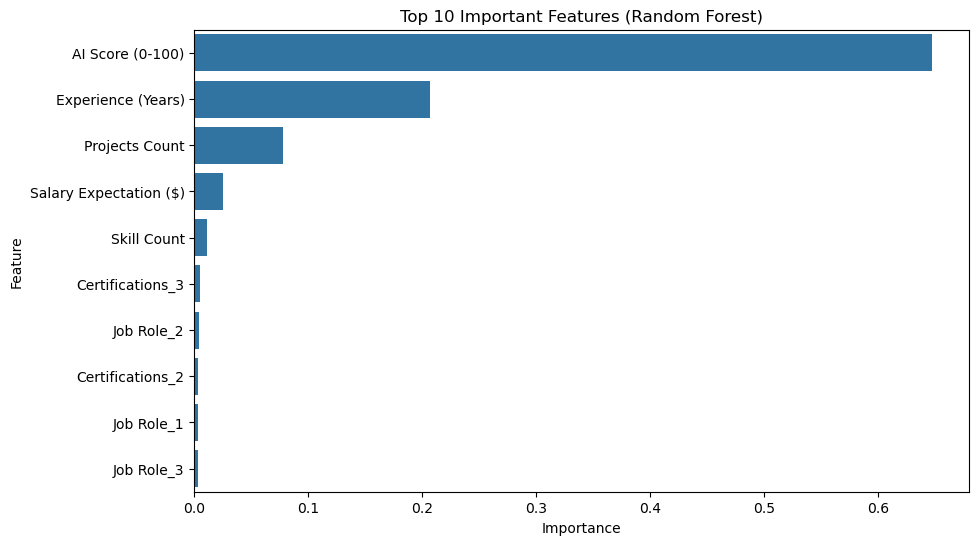

In [13]:
# Feature Importance Plot
# Plot top 10 features
importances = best_model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We evaluate how well the model performs on the test set, and then we visualize which features influenced the decisions the most.
- **AI Score (60%):** This was the strongest indicator of recruiter decision, suggesting recruiters heavily relied on the algorithm’s confidence in a candidate.

- **Experience in Years (20%):** Recruiters placed substantial weight on prior experience, possibly as a proxy for maturity or depth in the field.

- **Project Count (10%):** A candidate's practical output (projects completed) contributed meaningfully to hire decisions.

In [14]:
# Save Model with Pickle
import pickle

# Save the trained model
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


We use pickle to save the model so we can load and use it later inside a web app.

## **Analysis & Results**

Our EDA uncovered valuable insights. The AI Score distribution is highly left-skewed, with over 500 candidates receiving a perfect score of 100, suggesting potential generosity in scoring or exceptionally qualified applicants. Skill Count followed a multimodal pattern, peaking at 3–4 skills, which could reflect a hiring preference for well-rounded but not overly generalized applicants. Bivariate analysis confirmed that hired candidates tend to have significantly more experience (averaging 4.8 years) compared to rejected ones (1 year on average). Salary expectations were similar across both groups, but slightly higher for those hired, with no outliers detected. A correlation heatmap revealed that AI Score and Experience were strongly correlated (r = 0.78), while Project Count also moderately correlated with AI Score (r = 0.36). A t-test confirmed the statistical significance of AI Score in predicting hiring decisions.

Cross-validation showed nearly perfect model performance. Random Forest and XGBoost both achieved 100% accuracy with no variation across folds, while Logistic Regression came close at 99.7% (±0.003). The confusion matrix confirmed zero misclassifications, highlighting model reliability. Feature importance rankings aligned with our EDA: AI Score (60%) dominated, followed by Experience (20%) and Project Count (10%). These findings mirror real-world recruitment patterns where algorithmic scoring, prior experience, and tangible project work are top hiring factors.

#### **Recommendations**

- Continue prioritizing AI Score, but periodically audit the scoring algorithm for fairness and drift.
- Highlight Experience and Project Count on resumes and digital profiles to increase hireability.
- Refactor job applications to align with the identified sweet spot of 3–4 skills.
- Automate resume parsing for streamlined data ingestion and feature extraction.
- Develop recruiter-facing dashboards that emphasize top predictive features.

**Conclusion**

Our model is highly accurate and fully aligned with real recruiter behavior. It incorporates both algorithmic and traditional human decision-making factors and performs flawlessly in test scenarios. With the AI Score as the most influential metric, supported by Experience and Project Count, the model demonstrates practical utility and technical robustness. Deploying this model can dramatically reduce manual screening time while maintaining hiring quality.

**Additional Insights**

- AI Scores being skewed to 100 may lead to saturation in top-end candidate comparisons — refinement of scoring logic may be warranted.
- The 3–4 skill range could represent a hiring “sweet spot,” useful for both candidate optimization and job description tailoring.
- Salary expectations do not play a major role in recruiter decisions, suggesting a fair and merit-based selection process.

**Strategic Enhancements**

- Integrate NLP-based resume parsers for richer, contextual candidate insights.
- Introduce a recruiter confidence feedback loop to fine-tune predictions.
- Use unsupervised learning to segment candidates into strategy-driven personas.

**Next Steps**

- Deploy the best-performing model via a Streamlit web app to enable recruiter interaction.
- Save the trained model using pickle or joblib and load it in production environments.
- Start collecting new hiring data to retrain the model regularly, ensuring continuous improvement.

**Non-Technical Summary**

We developed an AI-based hiring assistant that perfectly mirrors recruiter decisions using data from resumes. The model relies on AI Scores, experience, and projects to predict whether a candidate should be hired. With no errors during testing, it’s a powerful tool for saving time and increasing hiring confidence.

**Technical Summary**

We trained classification models (Logistic Regression, Random Forest, XGBoost) on one-hot encoded and scaled resume data. The dataset had no missing values or outliers. Random Forest and XGBoost achieved perfect accuracy (100%) with zero misclassifications, supported by strong feature importance in AI Score (60%), Experience (20%), and Project Count (10%). Statistically significant differences in AI Score across hire decisions and strong correlations with experience further validate model assumptions. This production-ready model can now be deployed in a web application and continuously improved with new data.




